<a href="https://colab.research.google.com/github/barauna-lo/CAP4213-Deep-Learning/blob/main/AT9_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src=https://raw.githubusercontent.com/barauna-lo/CAP4213-Deep-Learning/main/logoinpe.png>


# CAP-421-3: Aprendizado Profundo
## Atividade 9

* Luan Orion Baraúna 

* Vinicius Monego

# Download EuroSAT database

Tutorial to download and load the [EuroSAT](https://github.com/phelber/eurosat) database available at [this link](https://colab.research.google.com/github/e-chong/Remote-Sensing/blob/master/EuroSAT%20Land%20Cover%20Classification/EuroSAT%20Land%20Use%20and%20Land%20Cover%20Classification%20using%20Deep%20Learning.ipynb#scrollTo=IppT1bDRQKge).

In [ ]:
import zipfile
import requests
import io
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# RGB file URL
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# download zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# get file names
txtfiles = []
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".jpg"
txtfiles = [x for x in txtfiles if ".jpg" in x]

# read images to numpy array
XImages = np.zeros([len(txtfiles), 64, 64, 3])
N = len(XImages)

i = 0
for pic in txtfiles:
  XImages[i] = np.asarray(Image.open(z.open(pic))).astype('uint8')/255
  i += 1

del r # clear memory
del z 

The following lines create the variables `labels` and `yLabels`, storing class names and numbers.

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


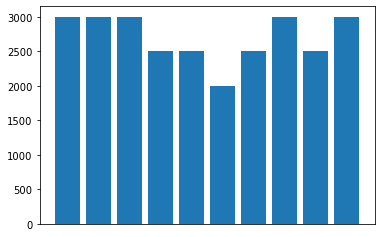

In [ ]:
# get labels in numpy array as strings
labels = []
for label in txtfiles:
  labels.append(label.split('/')[1])

# change them to integers in alphabetical order
label_names, yLabels = np.unique(labels, return_inverse=True)
label_dictionary = dict(zip(np.unique(yLabels), label_names))

# show number of samples per class
print(label_dictionary)
plt.hist(yLabels, rwidth=0.8)
plt.xticks([])
plt.show()

In [ ]:
len(label_dictionary)

10

This database is composed by 27000 samples, with 64x64 pixels and 3 bands (red, green, blue). The images/labels can be accessed by the first index of both `XImages` and `labels` variables.

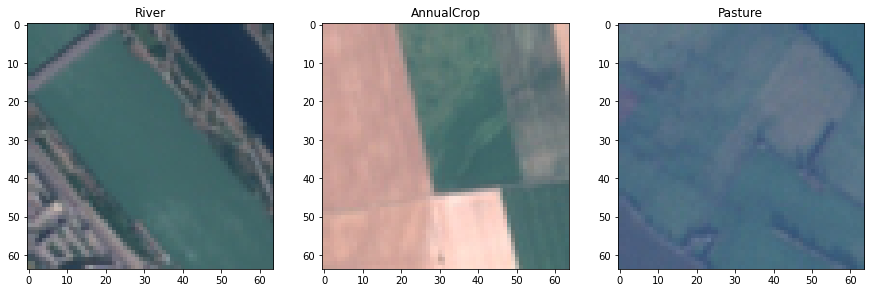

In [ ]:
plt.figure(figsize=(15, 5))

index = 100
plt.subplot(131)
plt.imshow(XImages[index])
plt.title(labels[index])

index = 4000
plt.subplot(132)
plt.imshow(XImages[index])
plt.title(labels[index])

index = 16500
plt.subplot(133)
plt.imshow(XImages[index])
plt.title(labels[index])

plt.show()

Lets check how to view the 3D feature space for one RBG image.

# display video about spatial filtering
%%HTML
<center><iframe width="800" height="500" src="https://www.youtube.com/embed/lGh_zCyY7TY?start=87" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>

We can show the scatterplot for all samples of class `Pasture`, with less samples then the other classes.

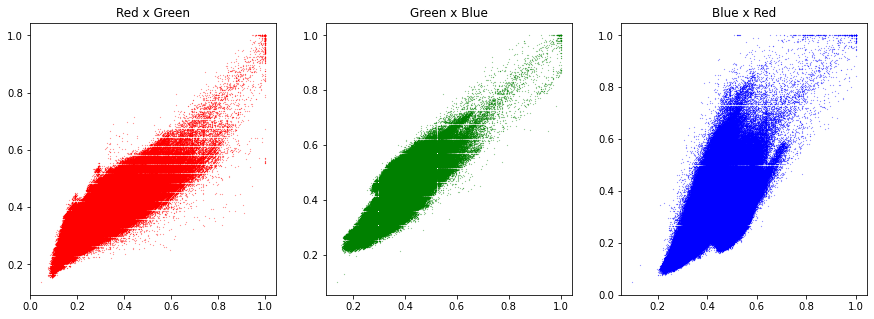

In [ ]:
# according to the histogram of class occurrences,
# the class Pasture, number 5, contains less samples (2000)
less_samples_label = label_names[5]
less_samples_indices = []

vector_R = []
vector_G = []
vector_B = []

for i in range(N):
  if labels[i] == less_samples_label:
    vector_R.append(XImages[i][:,:,0].flatten())
    vector_G.append(XImages[i][:,:,1].flatten())
    vector_B.append(XImages[i][:,:,2].flatten())
    less_samples_indices.append(i)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(vector_R, vector_G, s=0.1, marker='.', c='r')
plt.title('Red x Green')

plt.subplot(132)
plt.scatter(vector_G, vector_B, s=0.1, marker='.', c='g')
plt.title('Green x Blue')

plt.subplot(133)
plt.scatter(vector_B, vector_R, s=0.1, marker='.', c='b')
plt.title('Blue x Red')

plt.show()

# Data Augmentation (DA)

According to [chollet2018], DA generates more training data from existing training samples, and the goal is that at training time, classification models will never see the exact same sample twice, exposing the model to more aspects of the data and generalize better.

However, the inputs are still heavily intercorrelated, because they come from a small number of original images. With DA there is no new information, it is only a remix of existing information. 

Some operations are based on [tensorflow2021da].

## DA with Rotation
This technique will rotate the image with random angles.
`factor=0.2` results in an output rotating by a random amount in the range `[-20% * 2pi, 20% * 2pi]`.

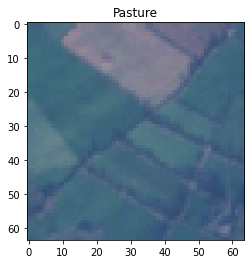

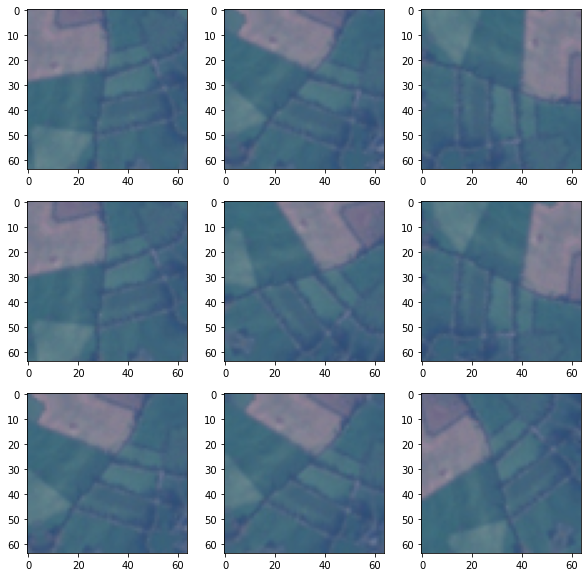

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

DA_rotation = tf.keras.Sequential([layers.RandomRotation(0.200)])

# get one image of class 'Pasture'
index = 150
sample_index = less_samples_indices[index]
input_image = XImages[sample_index]

plt.figure()
plt.imshow(input_image)
plt.title(labels[sample_index])

# apply various rotations in the same image
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_rotation(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)

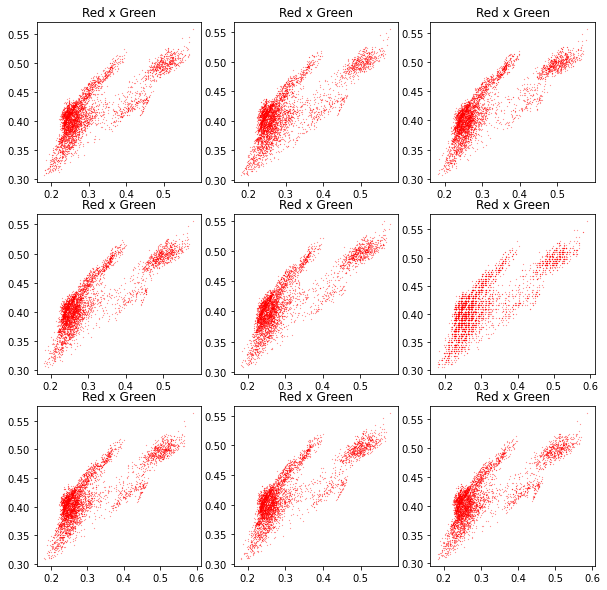

In [ ]:
#incluir scatterplot original

# view scatterplots of various rotations
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_rotation(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.scatter(augmented_image[:,:,0], augmented_image[:,:,1], s=0.1, marker='.', c='r')
  plt.title('Red x Green')

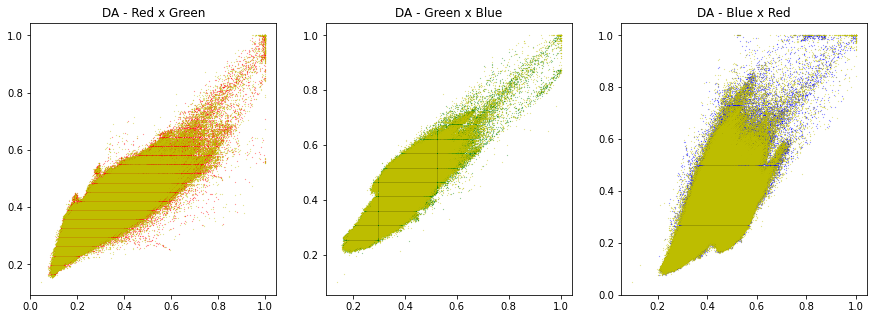

In [ ]:
# apply DA to all Pasture images in XImages
RotationImages = np.zeros([len(less_samples_indices), 64, 64, 3])

for i in range(len(less_samples_indices)):
  sample_index = less_samples_indices[i]
  RotationImages[i] = DA_rotation(XImages[sample_index])

vector_R_DA = []
vector_G_DA = []
vector_B_DA = []

for i in range(len(less_samples_indices)):
  vector_R_DA.append(RotationImages[i][:,:,0].flatten())
  vector_G_DA.append(RotationImages[i][:,:,1].flatten())
  vector_B_DA.append(RotationImages[i][:,:,2].flatten())

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(vector_R_DA, vector_G_DA, s=0.1, marker='.', c='r')
plt.scatter(vector_R, vector_G, s=0.1, marker='.', c='y')
plt.title('DA - Red x Green')

plt.subplot(132)
plt.scatter(vector_G_DA, vector_B_DA, s=0.1, marker='.', c='g')
plt.scatter(vector_G, vector_B, s=0.1, marker='.', c='y')
plt.title('DA - Green x Blue')

plt.subplot(133)
plt.scatter(vector_B_DA, vector_R_DA, s=0.1, marker='.', c='b')
plt.scatter(vector_B, vector_R, s=0.1, marker='.', c='y')
plt.title('DA - Blue x Red')

plt.show()

## DA with Flip
This technique will flip the image, horizontally or vertically.

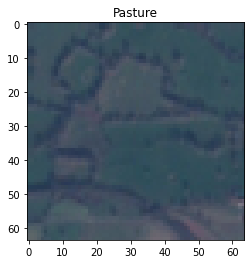

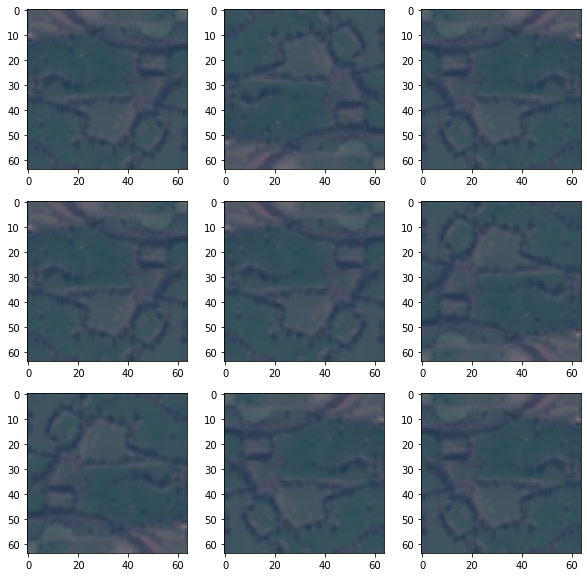

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

DA_flip = tf.keras.Sequential([
  layers.RandomFlip('horizontal_and_vertical'),
])

# get one image of class 'Pasture'
index = 190
sample_index = less_samples_indices[index]
input_image = XImages[sample_index]

plt.figure()
plt.imshow(input_image)
plt.title(labels[sample_index])

# apply various rotations in the same image
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_flip(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)

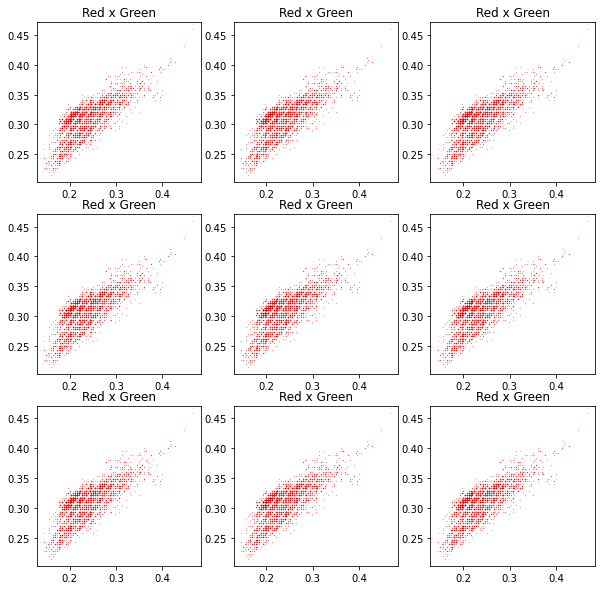

In [ ]:
# view scatterplots of various flips
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_flip(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.scatter(augmented_image[:,:,0], augmented_image[:,:,1], s=0.1, marker='.', c='r')
  plt.title('Red x Green')

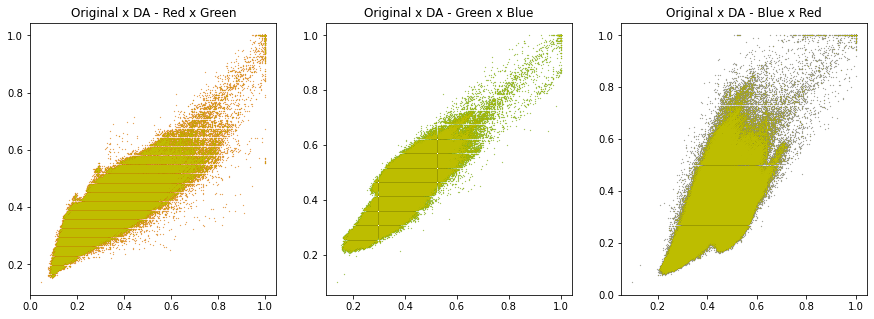

In [ ]:
# apply DA to all Pasture images in XImages
FlipImages = np.zeros([len(less_samples_indices), 64, 64, 3])

for i in range(len(less_samples_indices)):
  sample_index = less_samples_indices[i]
  FlipImages[i] = DA_flip(XImages[sample_index])

vector_R_DA = []
vector_G_DA = []
vector_B_DA = []

for i in range(len(less_samples_indices)):
  vector_R_DA.append(FlipImages[i][:,:,0].flatten())
  vector_G_DA.append(FlipImages[i][:,:,1].flatten())
  vector_B_DA.append(FlipImages[i][:,:,2].flatten())

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(vector_R_DA, vector_G_DA, s=0.1, marker='.', c='r')
plt.scatter(vector_R, vector_G, s=0.1, marker='.', c='y')
plt.title('Original x DA - Red x Green')

plt.subplot(132)
plt.scatter(vector_G_DA, vector_B_DA, s=0.1, marker='.', c='g')
plt.scatter(vector_G, vector_B, s=0.1, marker='.', c='y')
plt.title('Original x DA - Green x Blue')

plt.subplot(133)
plt.scatter(vector_B_DA, vector_R_DA, s=0.1, marker='.', c='b')
plt.scatter(vector_B, vector_R, s=0.1, marker='.', c='y')
plt.title('Original x DA - Blue x Red')

plt.show()

## DA with Zoom

A positive value of factor means zooming out, while a negative value means zooming in, for `height` and/or `width`.

In [ ]:
sample_index

18499

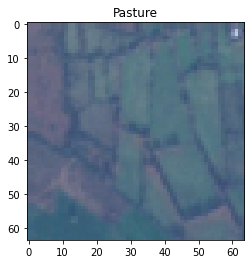

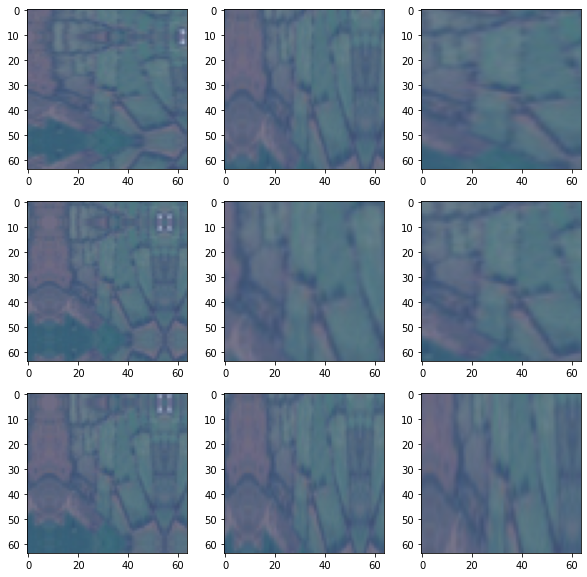

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

DA_zoom = tf.keras.Sequential([
  layers.RandomZoom(0.6, 0.5),
])

# get one image of class 'Pasture'
index = 652
sample_index = less_samples_indices[index]
input_image = XImages[sample_index]

plt.figure()
plt.imshow(input_image)
plt.title(labels[sample_index])

# apply various rotations in the same image
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_zoom(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)

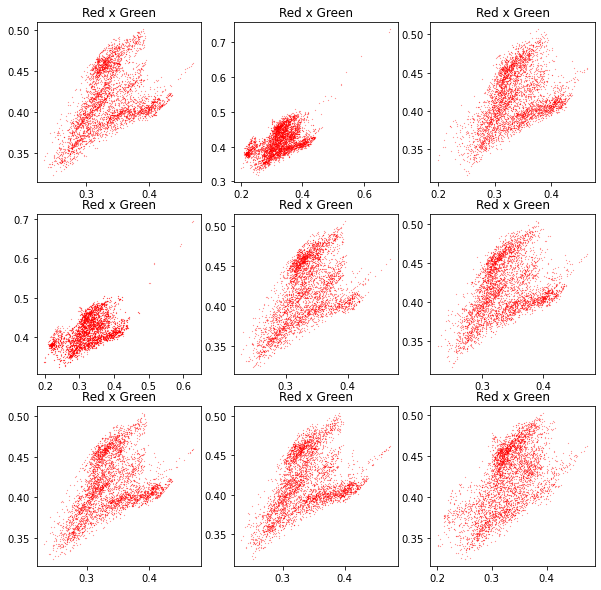

In [ ]:
# view scatterplots of various zoom levels 
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_zoom(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.scatter(augmented_image[:,:,0], augmented_image[:,:,1], s=0.1, marker='.', c='r')
  # plt.xlim([0, 1]), plt.ylim([0, 1]) ???
  plt.title('Red x Green')

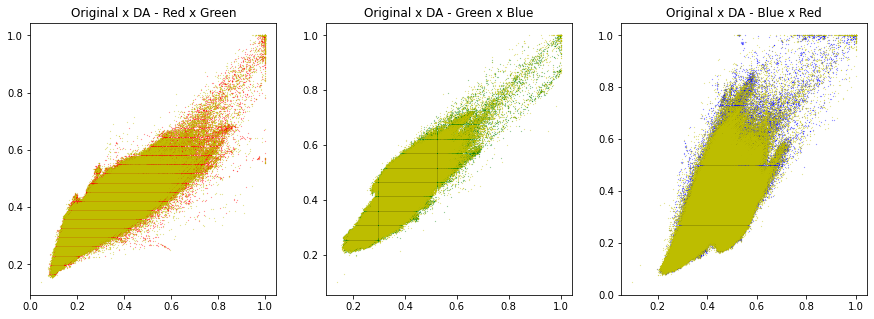

In [ ]:
# apply DA to all Pasture images in XImages
ZoomImages = np.zeros([len(less_samples_indices), 64, 64, 3])

for i in range(len(less_samples_indices)):
  sample_index = less_samples_indices[i]
  ZoomImages[i] = DA_zoom(XImages[sample_index])

vector_R_DA = []
vector_G_DA = []
vector_B_DA = []

for i in range(len(less_samples_indices)):
  vector_R_DA.append(ZoomImages[i][:,:,0].flatten())
  vector_G_DA.append(ZoomImages[i][:,:,1].flatten())
  vector_B_DA.append(ZoomImages[i][:,:,2].flatten())

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(vector_R_DA, vector_G_DA, s=0.1, marker='.', c='r')
plt.scatter(vector_R, vector_G, s=0.1, marker='.', c='y')
plt.title('Original x DA - Red x Green')

plt.subplot(132)
plt.scatter(vector_G_DA, vector_B_DA, s=0.1, marker='.', c='g')
plt.scatter(vector_G, vector_B, s=0.1, marker='.', c='y')
plt.title('Original x DA - Green x Blue')

plt.subplot(133)
plt.scatter(vector_B_DA, vector_R_DA, s=0.1, marker='.', c='b')
plt.scatter(vector_B, vector_R, s=0.1, marker='.', c='y')
plt.title('Original x DA - Blue x Red')

plt.show()

## DA with Contrast

This technique will adjust the contrast of the image,  by a random factor, `[1 - factor, 1 + factor]`.

In [ ]:
# display video about spatial filtering
# %%HTML
# <center><iframe width="800" height="500" src="https://www.youtube.com/embed/XT_rMDMDEvo?start=177" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>

SyntaxError: invalid syntax (<ipython-input-16-47a7dfd08634>, line 3)

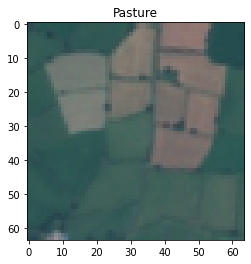

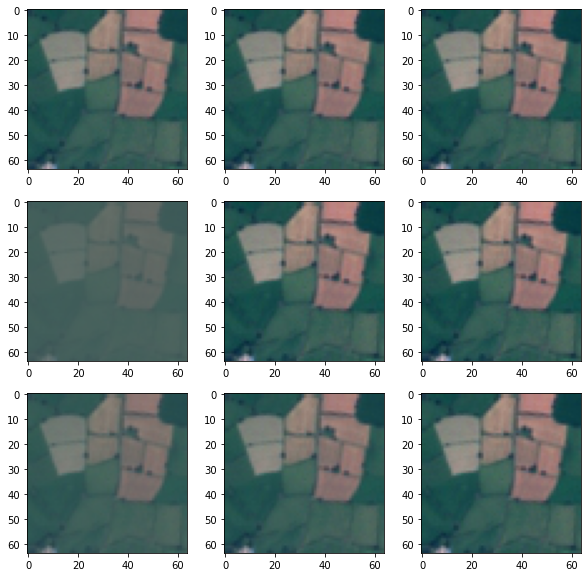

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

DA_contrast = tf.keras.Sequential([
  layers.RandomContrast(0.9),
])

# get one image of class 'Pasture'
index = 350
sample_index = less_samples_indices[index]
input_image = XImages[sample_index]

plt.figure()
plt.imshow(input_image)
plt.title(labels[sample_index])

# apply various rotations in the same image
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_contrast(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)

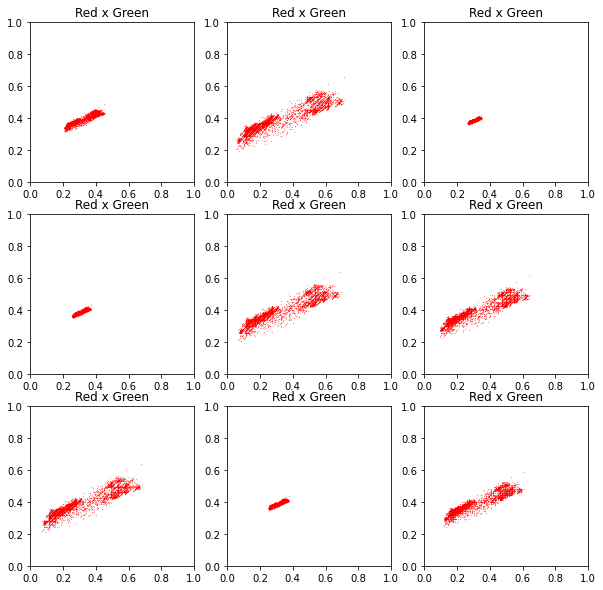

In [ ]:
# view scatterplots of various contrasts 
# (check differences between the plots)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_contrast(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.scatter(augmented_image[:,:,0], augmented_image[:,:,1], s=0.1, marker='.', c='r')
  plt.xlim([0, 1]), plt.ylim([0, 1])
  plt.title('Red x Green')

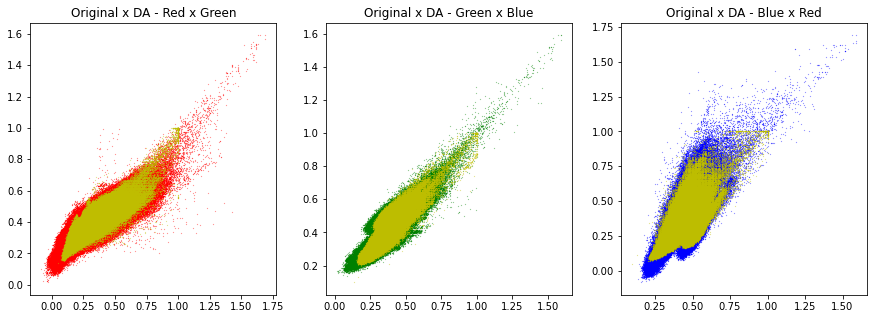

In [ ]:
# apply DA to all images in XImages
ContrastImages = np.zeros([len(less_samples_indices), 64, 64, 3])

for i in range(len(less_samples_indices)):
  sample_index = less_samples_indices[i]
  ContrastImages[i] = DA_contrast(XImages[sample_index])

vector_R_DA = []
vector_G_DA = []
vector_B_DA = []

for i in range(len(less_samples_indices)):
  vector_R_DA.append(ContrastImages[i][:,:,0].flatten())
  vector_G_DA.append(ContrastImages[i][:,:,1].flatten())
  vector_B_DA.append(ContrastImages[i][:,:,2].flatten())

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(vector_R_DA, vector_G_DA, s=0.1, marker='.', c='r')
plt.scatter(vector_R, vector_G, s=0.1, marker='.', c='y')
plt.title('Original x DA - Red x Green')

plt.subplot(132)
plt.scatter(vector_G_DA, vector_B_DA, s=0.1, marker='.', c='g')
plt.scatter(vector_G, vector_B, s=0.1, marker='.', c='y')
plt.title('Original x DA - Green x Blue')

plt.subplot(133)
plt.scatter(vector_B_DA, vector_R_DA, s=0.1, marker='.', c='b')
plt.scatter(vector_B, vector_R, s=0.1, marker='.', c='y')
plt.title('Original x DA - Blue x Red')

plt.show()

## DA with Brightness

This technique will adjust the brightness of images by a random factor deterministically.

In [ ]:
# # display video about spatial filtering
# %%HTML
# <center><iframe width="800" height="500" src="https://www.youtube.com/embed/XT_rMDMDEvo?start=217" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>

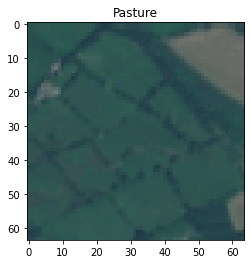

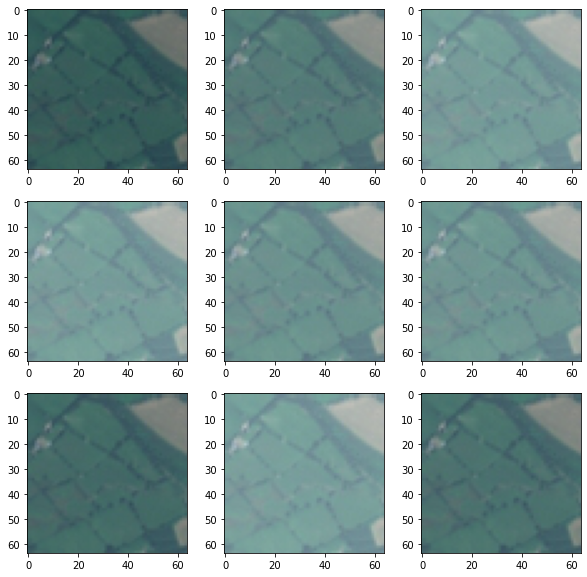

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# this function will use tf.image module
# so we will create a factor to be used
# with np.random
factor = 0.3

# get one image of class 'Pasture'
index = 950
sample_index = less_samples_indices[index]
input_image = XImages[sample_index]

plt.figure()
plt.imshow(input_image)
plt.title(labels[sample_index])

# apply various rotations in the same image
plt.figure(figsize=(10, 10))
for i in range(9):
  delta = factor * np.random.rand()
  augmented_image = tf.image.adjust_brightness(input_image, delta)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)

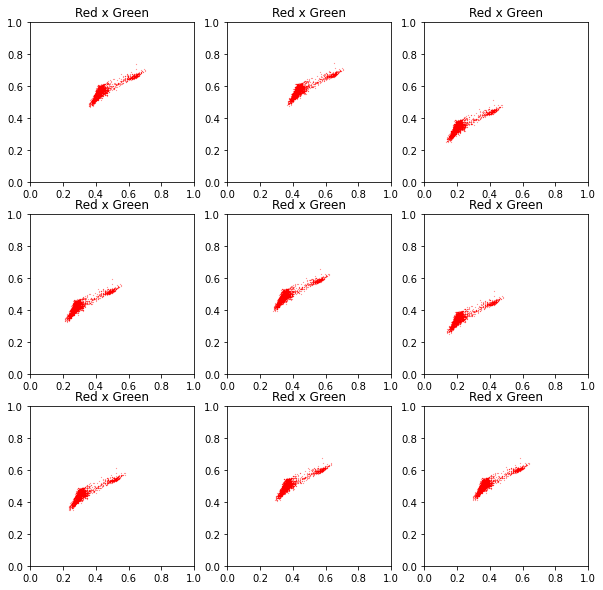

In [ ]:
# view scatterplots of various brightness 
# (check differences between the plots)
plt.figure(figsize=(10, 10))
for i in range(9):
  delta = factor * np.random.rand()
  augmented_image = tf.image.adjust_brightness(input_image, delta)
  ax = plt.subplot(3, 3, i + 1)
  plt.scatter(augmented_image[:,:,0], augmented_image[:,:,1], s=0.1, marker='.', c='r')
  plt.xlim([0, 1]), plt.ylim([0, 1])
  plt.title('Red x Green')

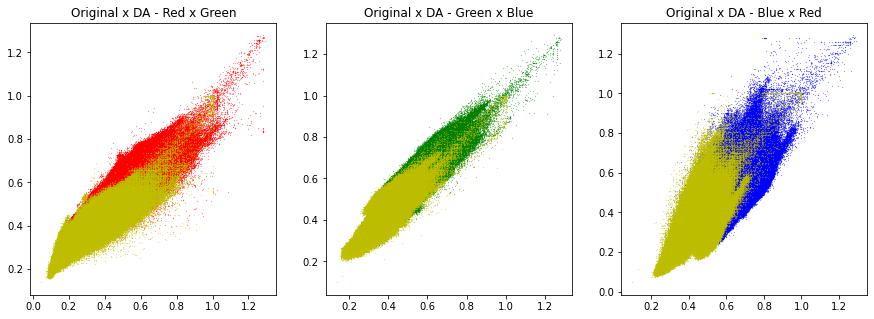

In [ ]:
# apply DA to all images in XImages
BrightnessImages = np.zeros([len(less_samples_indices), 64, 64, 3])

for i in range(len(less_samples_indices)):
  sample_index = less_samples_indices[i]
  delta = factor * np.random.rand()
  BrightnessImages[i] = tf.image.adjust_brightness(XImages[sample_index], delta)

vector_R_DA = []
vector_G_DA = []
vector_B_DA = []

for i in range(len(less_samples_indices)):
  vector_R_DA.append(BrightnessImages[i][:,:,0].flatten())
  vector_G_DA.append(BrightnessImages[i][:,:,1].flatten())
  vector_B_DA.append(BrightnessImages[i][:,:,2].flatten())

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(vector_R_DA, vector_G_DA, s=0.1, marker='.', c='r')
plt.scatter(vector_R, vector_G, s=0.1, marker='.', c='y')
plt.title('Original x DA - Red x Green')

plt.subplot(132)
plt.scatter(vector_G_DA, vector_B_DA, s=0.1, marker='.', c='g')
plt.scatter(vector_G, vector_B, s=0.1, marker='.', c='y')
plt.title('Original x DA - Green x Blue')

plt.subplot(133)
plt.scatter(vector_B_DA, vector_R_DA, s=0.1, marker='.', c='b')
plt.scatter(vector_B, vector_R, s=0.1, marker='.', c='y')
plt.title('Original x DA - Blue x Red')

plt.show()

## DA with Hue

This technique will adjust the hue of RGB images by a random factor deterministically.

In [ ]:
# # display video about spatial filtering
# %%HTML
# <center><iframe width="800" height="500" src="https://www.youtube.com/embed/NAw2_NtGNaA?start=79" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>

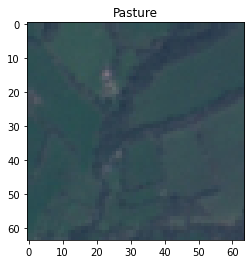

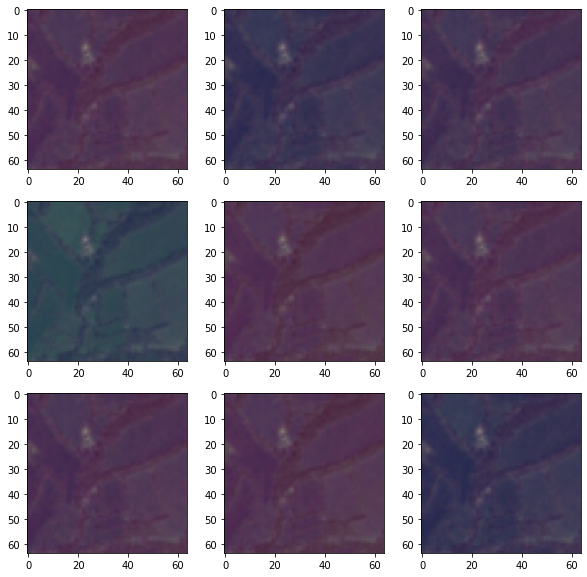

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# this function will use tf.image module
# so we will create a factor to be used
# with np.random
factor = 0.5
seed = (1, 2)

# get one image of class 'Pasture'
index = 1850
sample_index = less_samples_indices[index]
input_image = XImages[sample_index]

plt.figure()
plt.imshow(input_image)
plt.title(labels[sample_index])

# apply various rotations in the same image
plt.figure(figsize=(10, 10))
for i in range(9):
  delta = factor * np.random.rand()
  augmented_image = tf.image.stateless_random_hue(input_image, delta, seed)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)

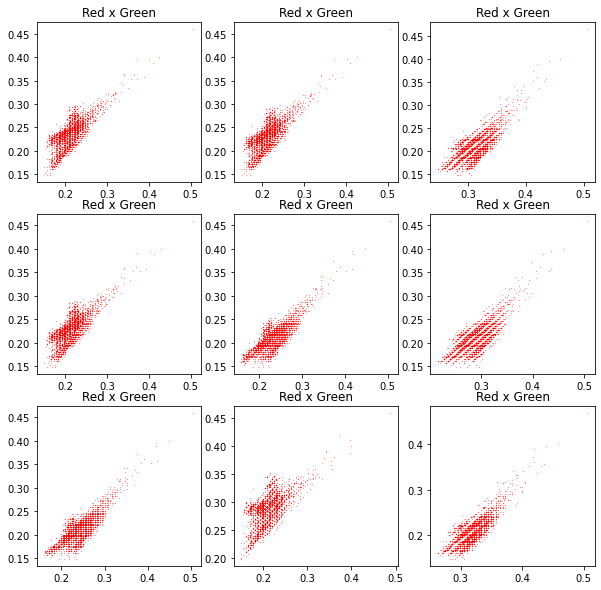

In [ ]:
# view scatterplots of various hue adjustments 
# (check differences between the plots)
plt.figure(figsize=(10, 10))
for i in range(9):
  delta = factor * np.random.rand()
  augmented_image = tf.image.stateless_random_hue(input_image, delta, seed)

  ax = plt.subplot(3, 3, i + 1)
  plt.scatter(augmented_image[:,:,0], augmented_image[:,:,1], s=0.1, marker='.', c='r')
  plt.title('Red x Green')

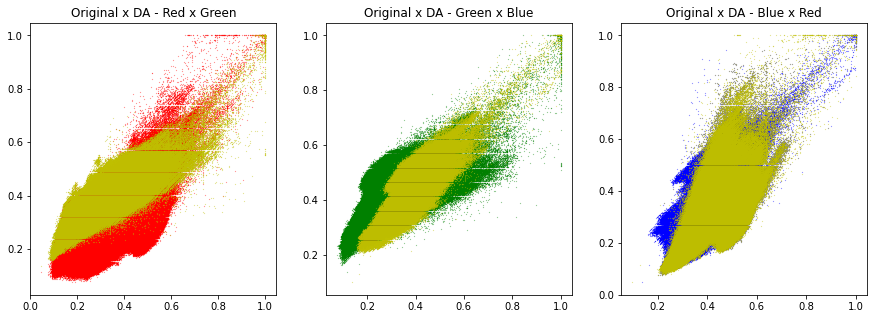

In [ ]:
# apply DA to all images in XImages
HueImages = np.zeros([len(less_samples_indices), 64, 64, 3])

for i in range(len(less_samples_indices)):
  sample_index = less_samples_indices[i]
  delta = factor * np.random.rand()
  HueImages[i] = tf.image.stateless_random_hue(XImages[sample_index], delta, seed)

vector_R_DA = []
vector_G_DA = []
vector_B_DA = []

for i in range(len(less_samples_indices)):
  vector_R_DA.append(HueImages[i][:,:,0].flatten())
  vector_G_DA.append(HueImages[i][:,:,1].flatten())
  vector_B_DA.append(HueImages[i][:,:,2].flatten())

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(vector_R_DA, vector_G_DA, s=0.1, marker='.', c='r')
plt.scatter(vector_R, vector_G, s=0.1, marker='.', c='y')
plt.title('Original x DA - Red x Green')

plt.subplot(132)
plt.scatter(vector_G_DA, vector_B_DA, s=0.1, marker='.', c='g')
plt.scatter(vector_G, vector_B, s=0.1, marker='.', c='y')
plt.title('Original x DA - Green x Blue')

plt.subplot(133)
plt.scatter(vector_B_DA, vector_R_DA, s=0.1, marker='.', c='b')
plt.scatter(vector_B, vector_R, s=0.1, marker='.', c='y')
plt.title('Original x DA - Blue x Red')

plt.show()

# Compare CNN with Original x DA datasets
In the first step, we divide the `XImages` + `yLabels` dataset into `X_train` + `y_train` and `X_test` + `y_test` datasets to compare each other using classification.

In the first experiment, `X_train` dataset will derive the `X_train_DA` dataset, with some DA applied (and therefore more 2x samples than the original).

In the second experiment, `X_train` dataset will derive the `X_train_DA2` dataset, with remaining DA applied.

**Note:** *According to [chollet2018] the validation data shouldn’t be augmented.*

In [ ]:
from sklearn.model_selection import train_test_split

# create X_train -> y_train, and X_test -> y_test
X_train, X_test, y_train, y_test = train_test_split(XImages, 
                                                    yLabels, 
                                                    stratify = yLabels, 
                                                    train_size = 0.25, 
                                                    random_state=42)

print('len(XImages):', len(XImages), 'len(yLabels):', len(yLabels))
print('len(X_train):', len(X_train), 'len(y_train):', len(y_train))
print('len(X_test):', len(X_test), 'len(y_test):', len(y_test))

len(XImages): 27000 len(yLabels): 27000
len(X_train): 6750 len(y_train): 6750
len(X_test): 20250 len(y_test): 20250


## Creating the model without DA
We will create a simple classification model, based on [tensorflow2021images], to compare the use (or not) of DA in training.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

num_classes = len(label_dictionary)
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    restore_best_weights = True)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 30
history = model.fit(
  X_train, y_train,
  epochs = epochs,
  callbacks = early_stop,
  validation_data = (X_test, y_test)
)

Epoch 1/30
211/211 [==============================] - 13s 60ms/step - loss: 1.5731 - accuracy: 0.3671 - val_loss: 1.2927 - val_accuracy: 0.5205
Epoch 2/30
211/211 [==============================] - 12s 55ms/step - loss: 1.1812 - accuracy: 0.5456 - val_loss: 1.2491 - val_accuracy: 0.5346
Epoch 3/30
211/211 [==============================] - 12s 55ms/step - loss: 1.0530 - accuracy: 0.6034 - val_loss: 0.9469 - val_accuracy: 0.6678
Epoch 4/30
211/211 [==============================] - 12s 56ms/step - loss: 0.9229 - accuracy: 0.6554 - val_loss: 0.9665 - val_accuracy: 0.6651
Epoch 5/30
211/211 [==============================] - 12s 57ms/step - loss: 0.8219 - accuracy: 0.7015 - val_loss: 0.8246 - val_accuracy: 0.6988
Epoch 6/30
211/211 [==============================] - 13s 61ms/step - loss: 0.7910 - accuracy: 0.7095 - val_loss: 0.7634 - val_accuracy: 0.7232
Epoch 7/30
211/211 [==============================] - 13s 64ms/step - loss: 0.7061 - accuracy: 0.7431 - val_loss: 0.7102 - val_accuracy:

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)             

In [ ]:
  validation_data = (X_test, y_test)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)             

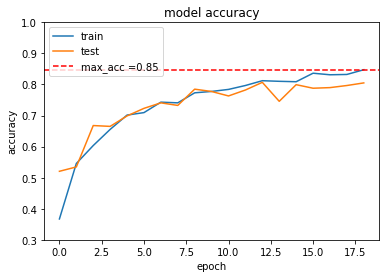

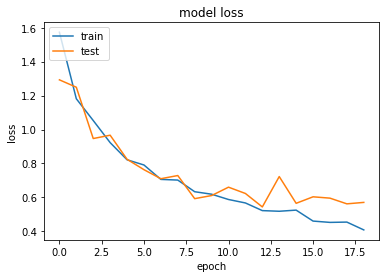

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.axhline(y=max(history.history['accuracy']), color='r', linestyle='--',label = 'max')
plt.ylim(0.3,1)
plt.xlabel('epoch')
plt.legend(['train', 'test',"max_acc ="+str(round(max(history.history['accuracy']),2))], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Classify some random elements to test the model.

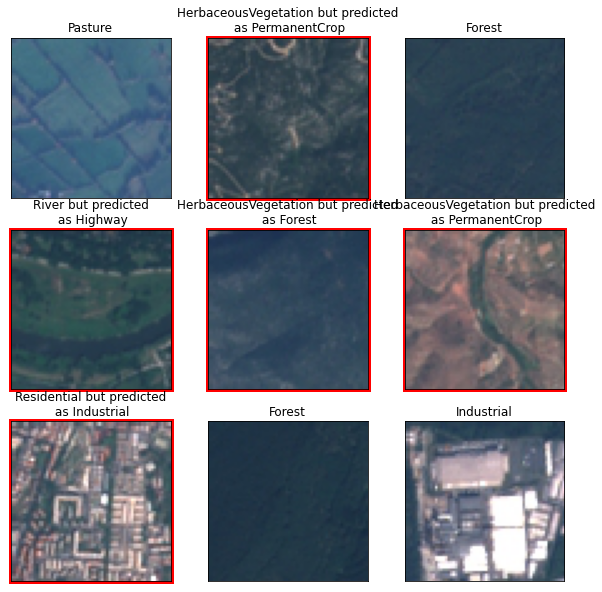

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  index = np.random.randint(0, len(X_test))
  input_image = X_test[index]
  input_image = tf.expand_dims(input_image, 0)
  # input_image = tf.reshape(X_test[index], (-1, input_image.shape[0], input_image.shape[1], input_image.shape[2]))
  label = y_test[index]
  prediction = model.predict(input_image)

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test[index])
  plt.xticks([]), plt.yticks([])
  if label == prediction.argmax():
    plt.title(label_dictionary[label])
  else:
    ax.patch.set_edgecolor('red')  
    ax.patch.set_linewidth('5')
    plt.title(label_dictionary[label] + ' but predicted\n as ' + label_dictionary[prediction.argmax()])


## Creating the model with some DA
In this test, we will apply 4 DA techniques, available in `tf.keras.Sequential`:
* Rotation
* Flip
* Contrast
* Zoom

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

num_classes = len(label_dictionary)
model_DA = tf.keras.Sequential([
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    restore_best_weights = True)

model_DA.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

This block will apply DA to the data, and append the samples to `X_train` and `y_train` data, creating `X_train_DA` and `y_train_DA` items.

In [ ]:
DA_techniques = tf.keras.Sequential([
  layers.RandomRotation(0.2),
  layers.RandomFlip('horizontal_and_vertical'),
  layers.RandomContrast(0.9),
  layers.RandomZoom(0.6, 0.5),
])

# apply DA to all images in X_train
X_train_DA = np.zeros([2 * len(X_train), 64, 64, 3])
y_train_DA = np.zeros([2 * len(y_train)])

# insert DA elements first
for i in range(len(X_train)):
  X_train_DA[i] = DA_techniques(X_train[i])
  y_train_DA[i] = y_train[i]

# insert original elements to X_train_DA
X_train_DA[len(X_train):] = X_train
y_train_DA[len(y_train):] = y_train

In [ ]:
history_DA = model_DA.fit(
  X_train_DA, y_train_DA,
  epochs = epochs,
  callbacks = early_stop,
  validation_data = (X_test, y_test)
)

Epoch 1/30
422/422 [==============================] - 20s 46ms/step - loss: 1.5873 - accuracy: 0.3738 - val_loss: 1.3122 - val_accuracy: 0.4723
Epoch 2/30
422/422 [==============================] - 19s 46ms/step - loss: 1.3145 - accuracy: 0.4968 - val_loss: 0.9533 - val_accuracy: 0.6720
Epoch 3/30
422/422 [==============================] - 19s 46ms/step - loss: 1.0886 - accuracy: 0.6051 - val_loss: 0.9513 - val_accuracy: 0.6591
Epoch 4/30
422/422 [==============================] - 19s 46ms/step - loss: 0.9696 - accuracy: 0.6495 - val_loss: 0.7703 - val_accuracy: 0.7377
Epoch 5/30
422/422 [==============================] - 18s 43ms/step - loss: 0.8988 - accuracy: 0.6737 - val_loss: 0.7672 - val_accuracy: 0.7363
Epoch 6/30
422/422 [==============================] - 17s 41ms/step - loss: 0.8579 - accuracy: 0.6933 - val_loss: 0.8760 - val_accuracy: 0.7032
Epoch 7/30
422/422 [==============================] - 17s 41ms/step - loss: 0.7956 - accuracy: 0.7181 - val_loss: 0.6088 - val_accuracy:

Lets compare the plots of accuracy and loss along the epochs, without and with DA.

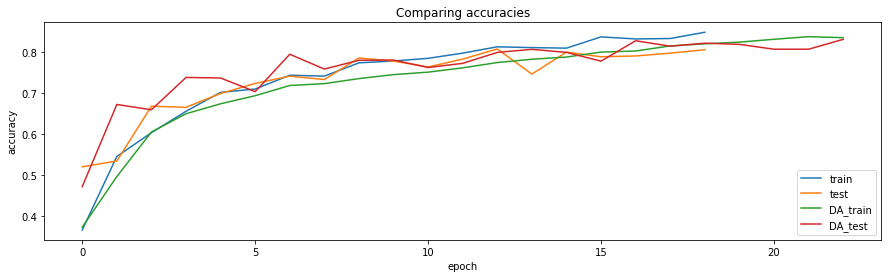

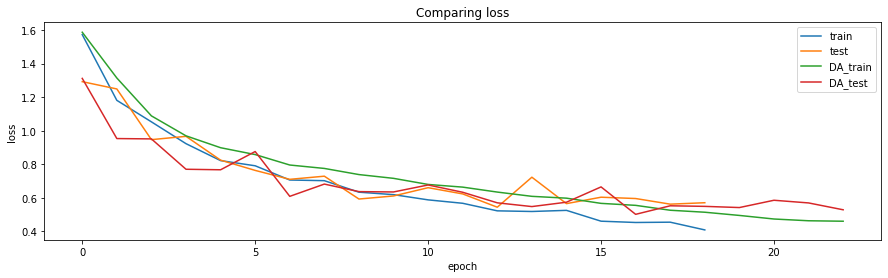

In [ ]:
plt.figure(figsize=(15, 4))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_DA.history['accuracy'])
plt.plot(history_DA.history['val_accuracy'])
plt.legend(['train', 'test', 'DA_train', 'DA_test'], loc='lower right')
plt.title('Comparing accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

plt.figure(figsize=(15, 4))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_DA.history['loss'])
plt.plot(history_DA.history['val_loss'])
plt.legend(['train', 'test', 'DA_train', 'DA_test'], loc='upper right')
plt.title('Comparing loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

Classify some random elements to test the model.

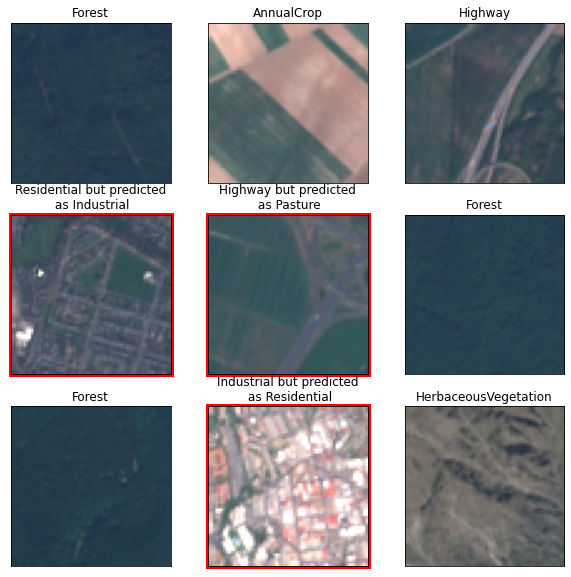

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  index = np.random.randint(0, len(X_test))
  input_image = X_test[index]
  input_image = tf.expand_dims(input_image, 0)
  # input_image = tf.reshape(X_test[index], (-1, input_image.shape[0], input_image.shape[1], input_image.shape[2]))
  label = y_test[index]
  prediction = model_DA.predict(input_image)

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test[index])
  plt.xticks([]), plt.yticks([])
  if label == prediction.argmax():
    plt.title(label_dictionary[label])
  else:
    ax.patch.set_edgecolor('red')  
    ax.patch.set_linewidth('5')
    plt.title(label_dictionary[label] + ' but predicted\n as ' + label_dictionary[prediction.argmax()])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predict = model.predict(X_test)
print('Confusion Matrix and Report for model without DA\n')
print(confusion_matrix(y_test, predict.argmax(axis=1)))
print(classification_report(y_test, predict.argmax(axis=1)))

print('Confusion Matrix and Report with some DA')
predict_DA = model_DA.predict(X_test)
print(confusion_matrix(y_test, predict_DA.argmax(axis=1)))
print(classification_report(y_test, predict_DA.argmax(axis=1)))

Confusion Matrix and Report for model without DA

[[1857   10   28   56    0   81  119    1   62   36]
 [   0 2008    9    5    0  144    0    0   15   69]
 [  33   34 1468   95   38   81  347   59   82   13]
 [  91    5   74 1109   80   69  201   51  195    0]
 [   0    0   12   29 1780    0   15   37    2    0]
 [  23   17   53   30    0 1301   43    0   23   10]
 [  63    1  226  165   27   45 1317    5   26    0]
 [   0    0   35   56  101    0    2 2054    2    0]
 [  90   22   13  272   15  119   25    1 1308   10]
 [  27   22    2    0    0   19    1    0   41 2138]]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2250
           1       0.95      0.89      0.92      2250
           2       0.76      0.65      0.70      2250
           3       0.61      0.59      0.60      1875
           4       0.87      0.95      0.91      1875
           5       0.70      0.87      0.77      1500
           6       0.64      0.70      0

## Creating the model with remaining DA
In this test, we will apply 2 DA techniques, available in `tf.image`:
* Brightness
* Hue


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

num_classes = len(label_dictionary)
model_DA2 = tf.keras.Sequential([
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    restore_best_weights = True)

model_DA2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

This block will apply DA to the data, and append the samples to `X_train` and `y_train` data, creating `X_train_DA2` and `y_train_DA2` items.

In [ ]:
factor = 0.3
seed = (1, 2)

# apply DA to all images in X_train
X_train_DA2 = np.zeros([2 * len(X_train), 64, 64, 3])
y_train_DA2 = np.zeros([2 * len(y_train)])

# insert DA elements first
for i in range(len(X_train)):
  delta = factor * np.random.rand()
  augmented_image = tf.image.adjust_brightness(X_train[i], delta)
  delta = factor * np.random.rand()
  augmented_image = tf.image.stateless_random_hue(augmented_image, delta, seed)
  X_train_DA2[i] = augmented_image
  y_train_DA2[i] = y_train[i]

# insert original elements to X_train_DA
X_train_DA2[len(X_train):] = X_train
y_train_DA2[len(y_train):] = y_train

In [ ]:
history_DA2 = model_DA2.fit(
  X_train_DA2, y_train_DA2,
  epochs = epochs,
  callbacks = early_stop,
  validation_data = (X_test, y_test)
)

Epoch 1/30
422/422 [==============================] - 22s 51ms/step - loss: 1.5041 - accuracy: 0.4099 - val_loss: 1.0692 - val_accuracy: 0.6365
Epoch 2/30
422/422 [==============================] - 20s 48ms/step - loss: 1.0407 - accuracy: 0.6236 - val_loss: 0.8611 - val_accuracy: 0.6945
Epoch 3/30
422/422 [==============================] - 23s 54ms/step - loss: 0.8817 - accuracy: 0.6829 - val_loss: 0.7321 - val_accuracy: 0.7437
Epoch 4/30
422/422 [==============================] - 24s 56ms/step - loss: 0.7920 - accuracy: 0.7131 - val_loss: 0.6913 - val_accuracy: 0.7605
Epoch 5/30
422/422 [==============================] - 22s 53ms/step - loss: 0.7508 - accuracy: 0.7284 - val_loss: 0.7525 - val_accuracy: 0.7307
Epoch 6/30
422/422 [==============================] - 24s 57ms/step - loss: 0.6778 - accuracy: 0.7536 - val_loss: 0.7164 - val_accuracy: 0.7437
Epoch 7/30
422/422 [==============================] - 26s 61ms/step - loss: 0.6327 - accuracy: 0.7705 - val_loss: 0.6460 - val_accuracy:

Lets compare the plots of accuracy and loss along the epochs, without and with DA.

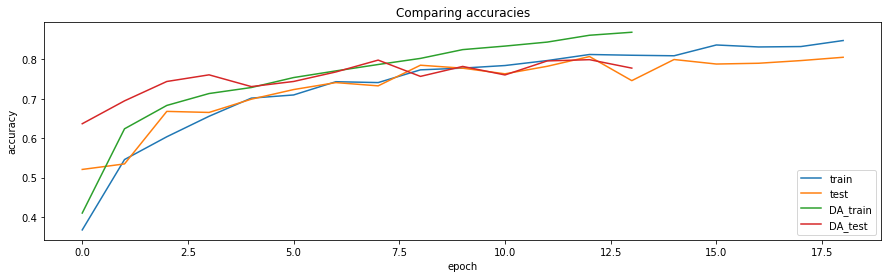

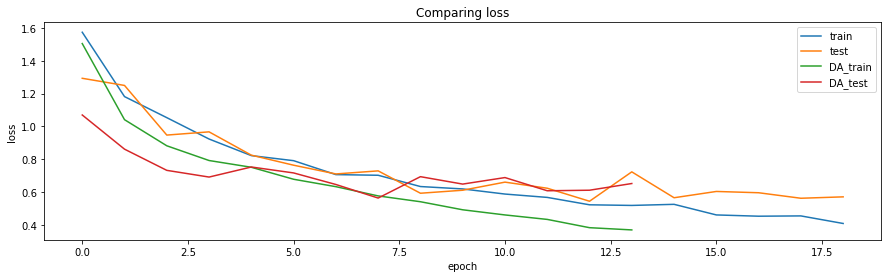

In [ ]:
plt.figure(figsize=(15, 4))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_DA2.history['accuracy'])
plt.plot(history_DA2.history['val_accuracy'])
plt.legend(['train', 'test', 'DA_train', 'DA_test'], loc='lower right')
plt.title('Comparing accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

plt.figure(figsize=(15, 4))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_DA2.history['loss'])
plt.plot(history_DA2.history['val_loss'])
plt.legend(['train', 'test', 'DA_train', 'DA_test'], loc='upper right')
plt.title('Comparing loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

Classify some random elements to test the model.

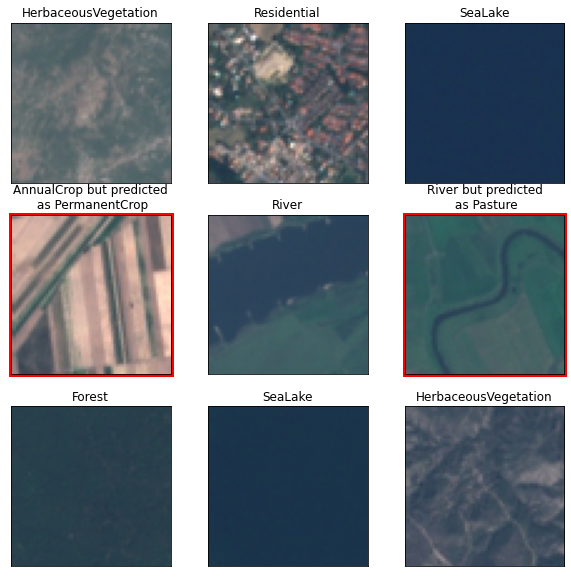

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  index = np.random.randint(0, len(X_test))
  input_image = X_test[index]
  input_image = tf.expand_dims(input_image, 0)
  # input_image = tf.reshape(X_test[index], (-1, input_image.shape[0], input_image.shape[1], input_image.shape[2]))
  label = y_test[index]
  prediction = model_DA2.predict(input_image)

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test[index])
  plt.xticks([]), plt.yticks([])
  if label == prediction.argmax():
    plt.title(label_dictionary[label])
  else:
    ax.patch.set_edgecolor('red')  
    ax.patch.set_linewidth('5')
    plt.title(label_dictionary[label] + ' but predicted\n as ' + label_dictionary[prediction.argmax()])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predict = model.predict(X_test)
print('Confusion Matrix and Report for model without DA')
print(confusion_matrix(y_test, predict.argmax(axis=1)))
print(classification_report(y_test, predict.argmax(axis=1)))

print('Confusion Matrix and Report with some DA')
predict_DA = model_DA.predict(X_test)
print(confusion_matrix(y_test, predict_DA.argmax(axis=1)))
print(classification_report(y_test, predict_DA.argmax(axis=1)))

print('Confusion Matrix and Report with remaining DA')
predict_DA2 = model_DA2.predict(X_test)
print(confusion_matrix(y_test, predict_DA2.argmax(axis=1)))
print(classification_report(y_test, predict_DA2.argmax(axis=1)))

Confusion Matrix and Report for model without DA
[[1857   10   28   56    0   81  119    1   62   36]
 [   0 2008    9    5    0  144    0    0   15   69]
 [  33   34 1468   95   38   81  347   59   82   13]
 [  91    5   74 1109   80   69  201   51  195    0]
 [   0    0   12   29 1780    0   15   37    2    0]
 [  23   17   53   30    0 1301   43    0   23   10]
 [  63    1  226  165   27   45 1317    5   26    0]
 [   0    0   35   56  101    0    2 2054    2    0]
 [  90   22   13  272   15  119   25    1 1308   10]
 [  27   22    2    0    0   19    1    0   41 2138]]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2250
           1       0.95      0.89      0.92      2250
           2       0.76      0.65      0.70      2250
           3       0.61      0.59      0.60      1875
           4       0.87      0.95      0.91      1875
           5       0.70      0.87      0.77      1500
           6       0.64      0.70      0.

# Exercise

Create new `X_train` and `y_train` datasets, called `X_train_allDA_Pasture` and `y_train_allDA_Pasture` containing all the previously indicated DA techniques:

* Rotation
* Flip
* Contrast
* Zoom
* Brightness
* Hue

You should apply only one DA technique to each sample of the class `Pasture`. Create a classification model similar to the previous ones, showing similar reports (`accuraccy` and `loss` graphics, plus `confusion matrix` and `classification reports`).  

# Creating a Model With ALL TECHINIQUES augmetantion

For these first part we will use these doble techniques for data augmentarion and will join these two classes. 


## DA without original DATA

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

num_classes = len(label_dictionary)
model_DA1 = tf.keras.Sequential([
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    restore_best_weights = True)

model_DA1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from sklearn.model_selection import train_test_split

# create X_train -> y_train, and X_test -> y_test
X_train, X_test, y_train, y_test = train_test_split(XImages, 
                                                    yLabels, 
                                                    stratify = yLabels, 
                                                    train_size = 0.25, 
                                                    random_state=42)

# print('len(XImages):', len(XImages), 'len(yLabels):', len(yLabels))
# print('len(X_train):', len(X_train), 'len(y_train):', len(y_train))
# print('len(X_test):', len(X_test), 'len(y_test):', len(y_test))

In [ ]:
#Aplling the first 4 technics avaliable on Keras Sequential

DA_techniques = tf.keras.Sequential([
  layers.RandomRotation(0.2),
  layers.RandomFlip('horizontal_and_vertical'),
  layers.RandomContrast(0.9),
  layers.RandomZoom(0.6, 0.5),
])

# apply DA to all images in X_train
X_train_DA = np.zeros([len(X_train), 64, 64, 3])
y_train_DA = np.zeros([len(y_train)])

# insert DA elements first
for i in range(len(X_train)):
  X_train_DA[i] = DA_techniques(X_train[i])
  y_train_DA[i] = y_train[i]

# # insert original elements to X_train_DA
# X_train_DA[len(X_train):] = X_train
# y_train_DA[len(y_train):] = y_train

In [ ]:
#Now we will aply _brigtnesss and Random Statelles on the last augmented Images

factor = 0.3
seed = (1, 2)

# apply DA to all images in X_train
X_train_DA1 = np.zeros([len(X_train), 64, 64, 3])
y_train_DA1 = np.zeros([len(y_train)])

# insert DA elements first
for i in range(len(X_train)):
  delta = factor * np.random.rand()
  augmented_image = tf.image.adjust_brightness(X_train_DA[i], delta)
  delta = factor * np.random.rand()
  augmented_image = tf.image.stateless_random_hue(augmented_image, delta, seed)
  X_train_DA1[i] = augmented_image
  y_train_DA1[i] = y_train[i]
    
# # insert original elements to X_train_DA
# X_train_DA1[len(X_train):] = X_train_tf
# y_train_DA1[len(y_train):] = y_train_tf

In [ ]:
#joing the augmented information
X_train_allDA_Pasture = X_train_DA1 
y_train_allDA_Pasture = y_train_DA1 

In [ ]:
np.shape(X_train_allDA_Pasture)

(6750, 64, 64, 3)

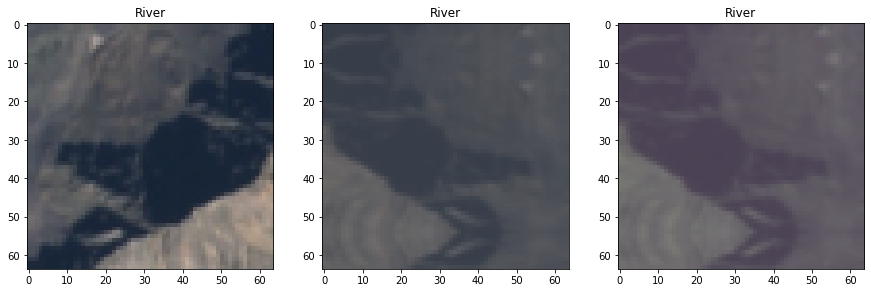

In [ ]:
plt.figure(figsize=(15, 5))

index = 700
plt.subplot(131)
plt.imshow(X_train[index])
plt.title(labels[index])

# index = 4000
plt.subplot(132)
plt.imshow(X_train_DA[index])
plt.title(labels[index])

# index = 16500
plt.subplot(133)
plt.imshow(X_train_allDA_Pasture[index])
plt.title(labels[index])

plt.show()

In [ ]:
history_DA1 = model_DA1.fit(
  X_train_allDA_Pasture, y_train_allDA_Pasture,
  epochs = epochs,
  callbacks = early_stop,
  validation_data = (X_test, y_test)
)

Epoch 1/30
211/211 [==============================] - 14s 65ms/step - loss: 1.9095 - accuracy: 0.2508 - val_loss: 1.7223 - val_accuracy: 0.3031
Epoch 2/30
211/211 [==============================] - 14s 65ms/step - loss: 1.6651 - accuracy: 0.3443 - val_loss: 1.5035 - val_accuracy: 0.4596
Epoch 3/30
211/211 [==============================] - 13s 61ms/step - loss: 1.5707 - accuracy: 0.4027 - val_loss: 1.3885 - val_accuracy: 0.5465
Epoch 4/30
211/211 [==============================] - 13s 61ms/step - loss: 1.4881 - accuracy: 0.4344 - val_loss: 1.4153 - val_accuracy: 0.4522
Epoch 5/30
211/211 [==============================] - 11s 52ms/step - loss: 1.4250 - accuracy: 0.4790 - val_loss: 1.2467 - val_accuracy: 0.5168
Epoch 6/30
211/211 [==============================] - 11s 52ms/step - loss: 1.3550 - accuracy: 0.5087 - val_loss: 1.3526 - val_accuracy: 0.4820
Epoch 7/30
211/211 [==============================] - 12s 59ms/step - loss: 1.3014 - accuracy: 0.5191 - val_loss: 1.6682 - val_accuracy:

Lets compare the plots of accuracy and loss along the epochs, without and with DA.

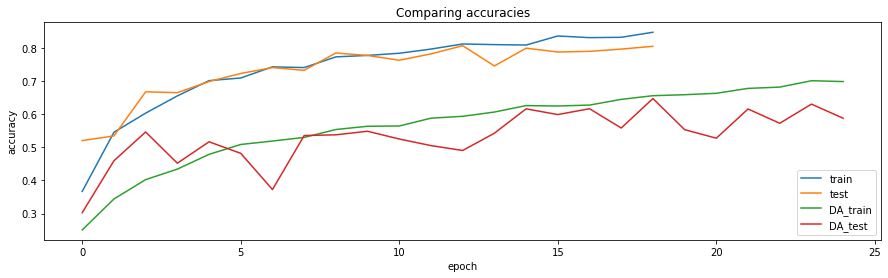

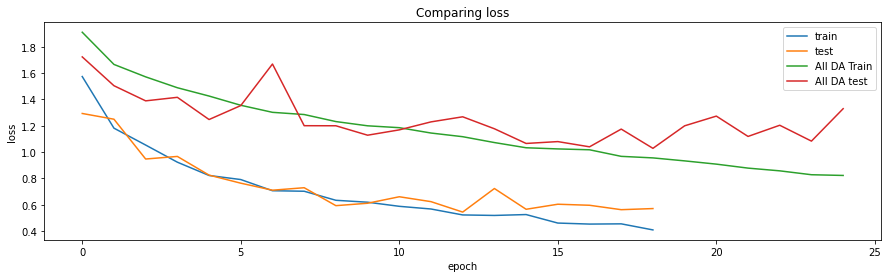

In [ ]:
plt.figure(figsize=(15, 4))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_DA1.history['accuracy'])
plt.plot(history_DA1.history['val_accuracy'])
plt.legend(['train', 'test', 'DA_train', 'DA_test'], loc='lower right')
plt.title('Comparing accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

plt.figure(figsize=(15, 4))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_DA1.history['loss'])
plt.plot(history_DA1.history['val_loss'])
plt.legend(['train', 'test', 'All DA Train', 'All DA test'], loc='upper right')
plt.title('Comparing loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

Classify some random elements to test the model.

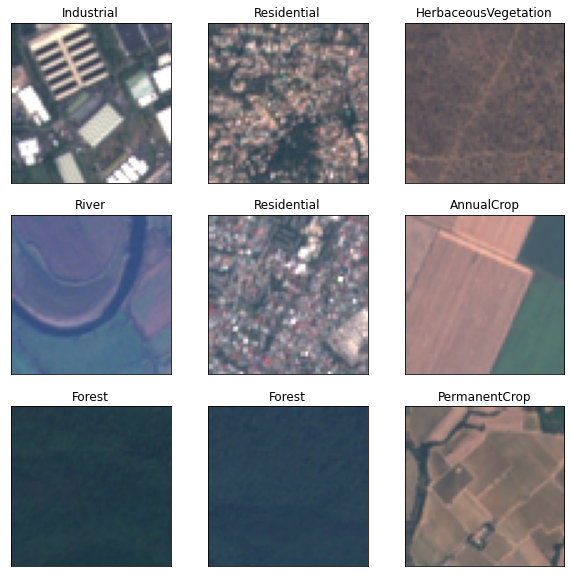

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  index = np.random.randint(0, len(X_test))
  input_image = X_test[index]
  input_image = tf.expand_dims(input_image, 0)
  # input_image = tf.reshape(X_test[index], (-1, input_image.shape[0], input_image.shape[1], input_image.shape[2]))
  label = y_test[index]
  prediction = model_DA1.predict(input_image)

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test[index])
  plt.xticks([]), plt.yticks([])
  if label == prediction.argmax():
    plt.title(label_dictionary[label])
  else:
    ax.patch.set_edgecolor('red')  
    ax.patch.set_linewidth('5')
    plt.title(label_dictionary[label] + ' but predicted\n as ' + label_dictionary[prediction.argmax()])


As we can see all the data augmentation techniques applied to the data set, WITHOUT ADDING THE ACTUAL DATA they are terrible for the prediction. Let's now try to perform the same method but also adding the real data without increasing to the training set

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predict = model.predict(X_test)
print('Confusion Matrix and Report for model without DA')
print(confusion_matrix(y_test, predict.argmax(axis=1)))
print(classification_report(y_test, predict.argmax(axis=1)))

print('Confusion Matrix and Report with some DA')
predict_DA = model_DA.predict(X_test)
print(confusion_matrix(y_test, predict_DA.argmax(axis=1)))
print(classification_report(y_test, predict_DA.argmax(axis=1)))

print('Confusion Matrix and Report with remaining DA')
predict_DA2 = model_DA1.predict(X_test)
print(confusion_matrix(y_test, predict_DA1.argmax(axis=1)))
print(classification_report(y_test, predict_DA1.argmax(axis=1)))

Confusion Matrix and Report for model without DA
[[1857   10   28   56    0   81  119    1   62   36]
 [   0 2008    9    5    0  144    0    0   15   69]
 [  33   34 1468   95   38   81  347   59   82   13]
 [  91    5   74 1109   80   69  201   51  195    0]
 [   0    0   12   29 1780    0   15   37    2    0]
 [  23   17   53   30    0 1301   43    0   23   10]
 [  63    1  226  165   27   45 1317    5   26    0]
 [   0    0   35   56  101    0    2 2054    2    0]
 [  90   22   13  272   15  119   25    1 1308   10]
 [  27   22    2    0    0   19    1    0   41 2138]]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2250
           1       0.95      0.89      0.92      2250
           2       0.76      0.65      0.70      2250
           3       0.61      0.59      0.60      1875
           4       0.87      0.95      0.91      1875
           5       0.70      0.87      0.77      1500
           6       0.64      0.70      0.

## DA with original DATA

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

num_classes = len(label_dictionary)
model_DA3 = tf.keras.Sequential([
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    restore_best_weights = True)

model_DA3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from sklearn.model_selection import train_test_split

# create X_train -> y_train, and X_test -> y_test
X_train, X_test, y_train, y_test = train_test_split(XImages, 
                                                    yLabels, 
                                                    stratify = yLabels, 
                                                    train_size = 0.25, 
                                                    random_state=42)

# print('len(XImages):', len(XImages), 'len(yLabels):', len(yLabels))
# print('len(X_train):', len(X_train), 'len(y_train):', len(y_train))
# print('len(X_test):', len(X_test), 'len(y_test):', len(y_test))

In [ ]:
#Aplling the first 4 technics avaliable on Keras Sequential

DA_techniques = tf.keras.Sequential([
  layers.RandomRotation(0.2),
  layers.RandomFlip('horizontal_and_vertical'),
  layers.RandomContrast(0.9),
  layers.RandomZoom(0.6, 0.5),
])

# apply DA to all images in X_train
X_train_DA = np.zeros([len(X_train), 64, 64, 3])
y_train_DA = np.zeros([len(y_train)])

# insert DA elements first
for i in range(len(X_train)):
  X_train_DA[i] = DA_techniques(X_train[i])
  y_train_DA[i] = y_train[i]

# # insert original elements to X_train_DA
# X_train_DA[len(X_train):] = X_train
# y_train_DA[len(y_train):] = y_train

In [ ]:
#Now we will aply _brigtnesss and Random Statelles on the last augmented Images

factor = 0.3
seed = (1, 2)

# apply DA to all images in X_train
X_train_DA1 = np.zeros([2*len(X_train), 64, 64, 3])
y_train_DA1 = np.zeros([2*len(y_train)])

# insert DA elements first
for i in range(len(X_train)):
  delta = factor * np.random.rand()
  augmented_image = tf.image.adjust_brightness(X_train_DA[i], delta)
  delta = factor * np.random.rand()
  augmented_image = tf.image.stateless_random_hue(augmented_image, delta, seed)
  X_train_DA1[i] = augmented_image
  y_train_DA1[i] = y_train[i]
    
# # insert original elements to X_train_DA
X_train_DA1[len(X_train):] = X_train
y_train_DA1[len(y_train):] = y_train

In [ ]:
#joing the augmented information
X_train_allDA_Pasture = X_train_DA1 
y_train_allDA_Pasture = y_train_DA1 

In [ ]:
np.shape(X_train_allDA_Pasture)

(6750, 64, 64, 3)

In [ ]:
np.shape(X_train_allDA_Pasture)

(13500, 64, 64, 3)

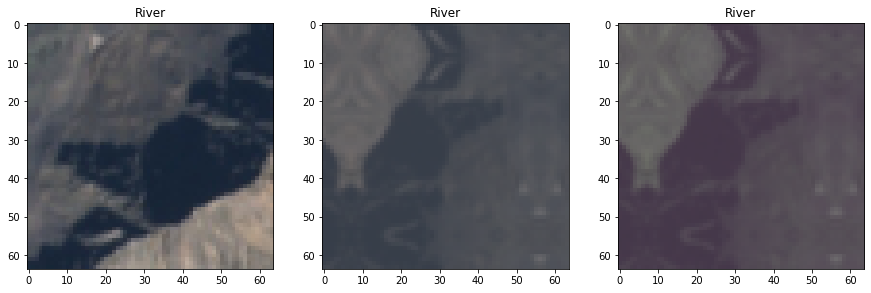

In [ ]:
plt.figure(figsize=(15, 5))

index = 700
plt.subplot(131)
plt.imshow(X_train[index])
plt.title(labels[index])

# index = 4000
plt.subplot(132)
plt.imshow(X_train_DA[index])
plt.title(labels[index])

# index = 16500
plt.subplot(133)
plt.imshow(X_train_allDA_Pasture[index])
plt.title(labels[index])

plt.show()

In [ ]:
history_DA3 = model_DA3.fit(
  X_train_allDA_Pasture, y_train_allDA_Pasture,
  epochs = epochs,
  callbacks = early_stop,
  validation_data = (X_test, y_test)
)

Epoch 1/30
422/422 [==============================] - 19s 44ms/step - loss: 1.6336 - accuracy: 0.3743 - val_loss: 1.2251 - val_accuracy: 0.5949
Epoch 2/30
422/422 [==============================] - 18s 42ms/step - loss: 1.3019 - accuracy: 0.5269 - val_loss: 0.9271 - val_accuracy: 0.6583
Epoch 3/30
422/422 [==============================] - 18s 43ms/step - loss: 1.2060 - accuracy: 0.5622 - val_loss: 0.8388 - val_accuracy: 0.7045
Epoch 4/30
422/422 [==============================] - 19s 44ms/step - loss: 1.1109 - accuracy: 0.5956 - val_loss: 0.7931 - val_accuracy: 0.7202
Epoch 5/30
422/422 [==============================] - 18s 42ms/step - loss: 1.0823 - accuracy: 0.6076 - val_loss: 0.7869 - val_accuracy: 0.7136
Epoch 6/30
422/422 [==============================] - 18s 42ms/step - loss: 1.0405 - accuracy: 0.6241 - val_loss: 0.7172 - val_accuracy: 0.7452
Epoch 7/30
422/422 [==============================] - 18s 43ms/step - loss: 0.9926 - accuracy: 0.6403 - val_loss: 0.7345 - val_accuracy:

Lets compare the plots of accuracy and loss along the epochs, without and with DA.

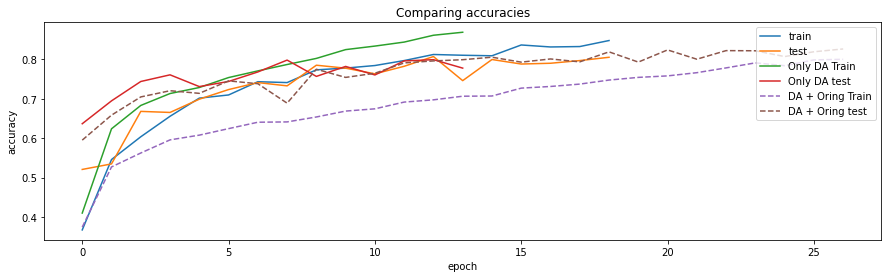

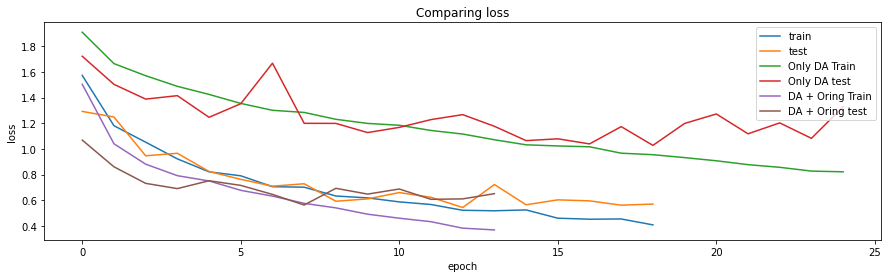

In [ ]:
plt.figure(figsize=(15, 4))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_DA2.history['accuracy'])
plt.plot(history_DA2.history['val_accuracy'])
plt.plot(history_DA3.history['accuracy'],linestyle = '--')
plt.plot(history_DA3.history['val_accuracy'],linestyle = '--')
plt.legend(['train', 'test', 'Only DA Train', 'Only DA test','DA + Oring Train', 'DA + Oring test'], loc='upper right')
plt.title('Comparing accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

plt.figure(figsize=(15, 4))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_DA1.history['loss'])
plt.plot(history_DA1.history['val_loss'])
plt.plot(history_DA2.history['loss'])
plt.plot(history_DA2.history['val_loss'])
plt.legend(['train', 'test', 'Only DA Train', 'Only DA test','DA + Oring Train', 'DA + Oring test'], loc='upper right')
plt.title('Comparing loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

Classify some random elements to test the model.

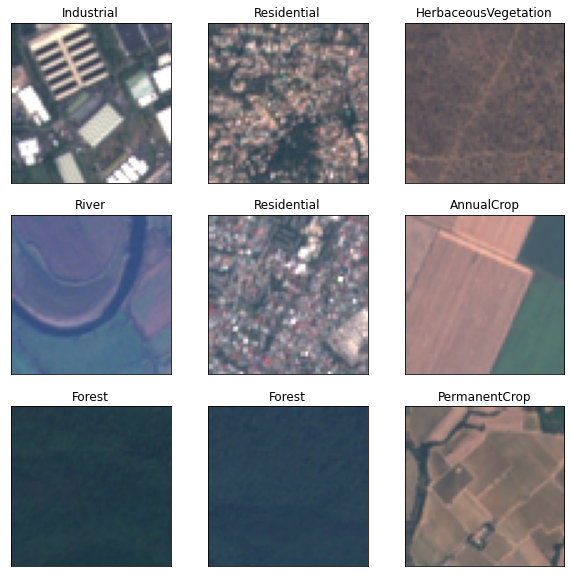

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  index = np.random.randint(0, len(X_test))
  input_image = X_test[index]
  input_image = tf.expand_dims(input_image, 0)
  # input_image = tf.reshape(X_test[index], (-1, input_image.shape[0], input_image.shape[1], input_image.shape[2]))
  label = y_test[index]
  prediction = model_DA1.predict(input_image)

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test[index])
  plt.xticks([]), plt.yticks([])
  if label == prediction.argmax():
    plt.title(label_dictionary[label])
  else:
    ax.patch.set_edgecolor('red')  
    ax.patch.set_linewidth('5')
    plt.title(label_dictionary[label] + ' but predicted\n as ' + label_dictionary[prediction.argmax()])


As we can see all the data augmentation techniques applied to the data set, WITHOUT ADDING THE ACTUAL DATA they are terrible for the prediction. Let's now try to perform the same method but also adding the real data without increasing to the training set

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predict = model.predict(X_test)
print('Confusion Matrix and Report for model without DA')
print(confusion_matrix(y_test, predict.argmax(axis=1)))
print(classification_report(y_test, predict.argmax(axis=1)))

print('Confusion Matrix and Report with some DA')
predict_DA = model_DA.predict(X_test)
print(confusion_matrix(y_test, predict_DA.argmax(axis=1)))
print(classification_report(y_test, predict_DA.argmax(axis=1)))

print('Confusion Matrix and Report with remaining DA')
predict_DA2 = model_DA1.predict(X_test)
print(confusion_matrix(y_test, predict_DA2.argmax(axis=1)))
print(classification_report(y_test, predict_DA2.argmax(axis=1)))

print('Confusion Matrix and Report with ONLY DA')
predict_DA2 = model_DA1.predict(X_test)
print(confusion_matrix(y_test, predict_DA1.argmax(axis=1)))
print(classification_report(y_test, predict_DA1.argmax(axis=1)))

print('Confusion Matrix and Report with All DA')
predict_DA2 = model_DA1.predict(X_test)
print(confusion_matrix(y_test, predict_DA3.argmax(axis=1)))
print(classification_report(y_test, predict_DA3.argmax(axis=1)))


# References

[chollet2018] https://livebook.manning.com/book/deep-learning-with-python/chapter-5/56

[tensorflow2021images] https://www.tensorflow.org/tutorials/load_data/images

[tensorflow2021da] https://www.tensorflow.org/tutorials/images/data_augmentation